In [2]:
from keras import layers
from keras import regularizers
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Dropout, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, concatenate, Conv1DTranspose
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import random
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
import pandas as pd
import os
import openpyxl as xls
from keras import backend as k
import cv2
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
tf.compat.v1.enable_eager_execution()
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\adarabi3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [3]:
X = pd.read_csv("one_speaker_pressure.csv")
Y= pd.read_csv("one_speaker_value.csv")

In [4]:
X=X[0:20000]
Y=Y[0:20000]
X_data = X.to_numpy()
Y_data = Y.to_numpy()
print(max(Y_data[200]))
print(min(X_data[200]))

X_data=X_data.reshape(-1,64,2)


print(X_data.shape)
print(Y_data.shape)


0.3
0.18
(20000, 64, 2)
(20000, 2)


In [5]:
def convert_to_one_hot(Y):
    n_values = np.max(Y)+1
    return np.squeeze(np.eye(n_values)[Y.reshape(-1)])

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.15, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17000, 64, 2)
(3000, 64, 2)
(17000, 2)
(3000, 2)


In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    X_shortcut = inputs
    
    conv = Conv1D(n_filters, # Number of filters
                  4,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = BatchNormalization(axis=2)(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv1D(n_filters, # Number of filters
                  4,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    conv = BatchNormalization(axis=2)(conv)

    X_shortcut = Conv1D(n_filters, # Number of filters
                  4,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(X_shortcut)
    X_shortcut = BatchNormalization(axis=2)(X_shortcut)


    conv = Add()([conv, X_shortcut])
    conv = Activation('relu')(conv)
    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling1D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv1DTranspose(
                 n_filters,# number of filters
                 4,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=2)
    
    conv = Conv1D(n_filters, # Number of filters
                  4,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = BatchNormalization(axis=2)(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv1D(n_filters, # Number of filters
                  4,# Kernel size   
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [12]:
def Sound_beaming(input_shape = (160, 3), f1=16,C1 = 75):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Stage 1
    cblock1 = conv_block(inputs=X_input, n_filters=f1*1)   #80*f1
    cblock2 = conv_block(inputs=cblock1[0], n_filters=f1*2)  #40*(2f1)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=f1*4)   #20*(4f1)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=f1*8,dropout_prob=0.3)    #10*(8f1)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=f1*16,dropout_prob=0.3,max_pooling=False)    #5*(16f1)


    # Stage 2
    ublock6 = upsampling_block(cblock5[0], cblock4[1], f1*8)    
    ublock7 = upsampling_block(ublock6, cblock3[1], f1*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], f1*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], f1*1)

    X = Conv1D(C1,
                 3,
                 activation='sigmoid',
                 padding='same',
                 kernel_initializer='he_normal',
                 kernel_regularizer=tf.keras.regularizers.l2(0.05))(ublock9)


    # output layer
    # X = Flatten()(ublock9)
    # X = Dense(C1, activation='sigmoid', name='fc' + str(C1), kernel_regularizer=tf.keras.regularizers.l2(0.05))(X)
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Sound_beaming')

    return model



In [9]:
learn_rate=0.001
rate=1/50
def decay_fun(epoch):
    lrate=learn_rate*np.exp(-rate*epoch)
    if lrate<5e-4:
        lrate=5e-4
    return lrate
    

In [10]:
lerate=LearningRateScheduler(decay_fun)
callback_list=[lerate]

In [21]:
model = Sound_beaming(input_shape = (64,2), f1=8, C1=2)

In [14]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [27]:
model.compile(tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "Sound_beaming"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64, 8)        104         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 8)       32          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 8)        0           ['batch_normalization

In [23]:
prediction=model.fit(x_train,x_train,epochs=50,batch_size=256, callbacks=callback_list,validation_data=(x_test,x_test))

Epoch 1/50
67/67 [==============================] - 8s 71ms/step - loss: 0.1808 - accuracy: 0.6892 - val_loss: 0.2856 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - 4s 65ms/step - loss: 0.1056 - accuracy: 0.8361 - val_loss: 0.1850 - val_accuracy: 0.5124 - lr: 9.8020e-04
Epoch 3/50
67/67 [==============================] - 4s 65ms/step - loss: 0.0731 - accuracy: 0.8894 - val_loss: 0.1320 - val_accuracy: 0.6243 - lr: 9.6079e-04
Epoch 4/50
67/67 [==============================] - 4s 66ms/step - loss: 0.0526 - accuracy: 0.9126 - val_loss: 0.0944 - val_accuracy: 0.7367 - lr: 9.4176e-04
Epoch 5/50
67/67 [==============================] - 4s 67ms/step - loss: 0.0387 - accuracy: 0.9248 - val_loss: 0.0698 - val_accuracy: 0.8498 - lr: 9.2312e-04
Epoch 6/50
67/67 [==============================] - 5s 69ms/step - loss: 0.0291 - accuracy: 0.9341 - val_loss: 0.0508 - val_accuracy: 0.9239 - lr: 9.0484e-04
Epoch 7/50
67/67 [==============================] - 4s 6

In [24]:
model.save('Sound_two_speakers')

INFO:tensorflow:Assets written to: Sound_two_speakers\assets


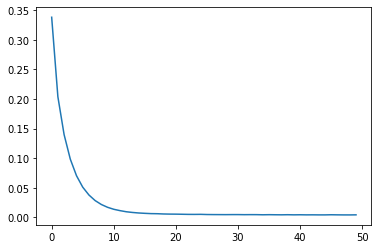

In [115]:
plt.plot(prediction.history["loss"])

In [84]:
preds = model.evaluate(x_test, x_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

94/94 [==============================] - 1s 7ms/step - loss: 0.4999 - accuracy: 0.9224
Loss = 0.4999387264251709
Test Accuracy = 0.9224062561988831


In [25]:
tf.config.run_functions_eagerly(False)
NN=200
X_dataa=X_data[NN]
X_dataa=X_dataa.reshape(1,64,3)
print(X_dataa.shape)
q=model.predict(X_dataa)
# mse = tf.keras.losses.MeanAbsoluteError()
# error=mse(q, Y_data[NN]).numpy
# print(error)
# print(q)
print(q-X_data[NN])
# data_y_print=Y_data[NN]
# print(data_y_print)

In [ ]:
writer=pd.ExcelWriter("data.xlsx")


In [ ]:
df1 = pd.DataFrame (q.T)
df2 = pd.DataFrame (data_y_print.T)


In [ ]:
df1.to_excel(writer,sheet_name='predicted', index=['C'])
df2.to_excel(writer,sheet_name='actual' , index=['C'])

In [ ]:
writer.save()